In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock

import time
from functools import wraps
from xml.etree import ElementTree

import pandas as pd
import numpy as np
from datetime import datetime, date
from pykrx import stock

import FinanceDataReader as fdr

In [2]:
def my_krx(start, end, *codes):
    error_list = []
    failed = 0
    success = 0
    for code in codes:
        try:
            df = stock.get_market_ohlcv_by_date(start, end, code)
            df.reset_index(inplace=True)
            df.insert(loc=1, column='종목코드', value=code)
            df.columns = ['date', 'code', 'open', 'high', 'low', 'close','volume']
            success += 1
        except ElementTree.ParseError as e:
            error_list.append(e)
            drop_rows(database, table, code)  # 특정 종목코드에서 에러 발생 시 해당 종목코드에 대한 데이터 삭제 후 다음 종목코드로 넘어감
            failed += 1
            continue
        except Exception as e:
            print('Error occurred : ', e)
            failed += 1
            continue
    print(f'success:{success}, failed:{failed}')
    return df

In [5]:
df = pd.DataFrame()
df = my_krx('20190101', '20210101', '005930')
df.head()

success:1, failed:0


,date,code,open,high,low,close,volume
0,2019-01-02,005930,39400,39400,38550,38750,7847664
1,2019-01-03,005930,38300,38550,37450,37600,12471493
2,2019-01-04,005930,37450,37600,36850,37450,14108958
3,2019-01-07,005930,38000,38900,37800,38750,12748997
4,2019-01-08,005930,38000,39200,37950,38100,12756554


In [6]:
df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20']+(df['stddev']*2)
df['lower'] = df['MA20']-(df['stddev']*2)
df['PB'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])

In [7]:
df['II'] = (2*df['close']-df['high']-df['low'])/(df['high']-df['low'])*df['volume']
df['IIP21'] = df['II'].rolling(window=21).sum()/df['volume'].rolling(window=21).sum()*100

# df = df.dropna()

- 종가가 거래 범위 천장권 1, 중간0, 바닥 -1
- 21일 기간 동안의 ii 합을 기간 동안의 거래량 합으로 나눠 표준화

c:\it\python37\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\it\python37\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


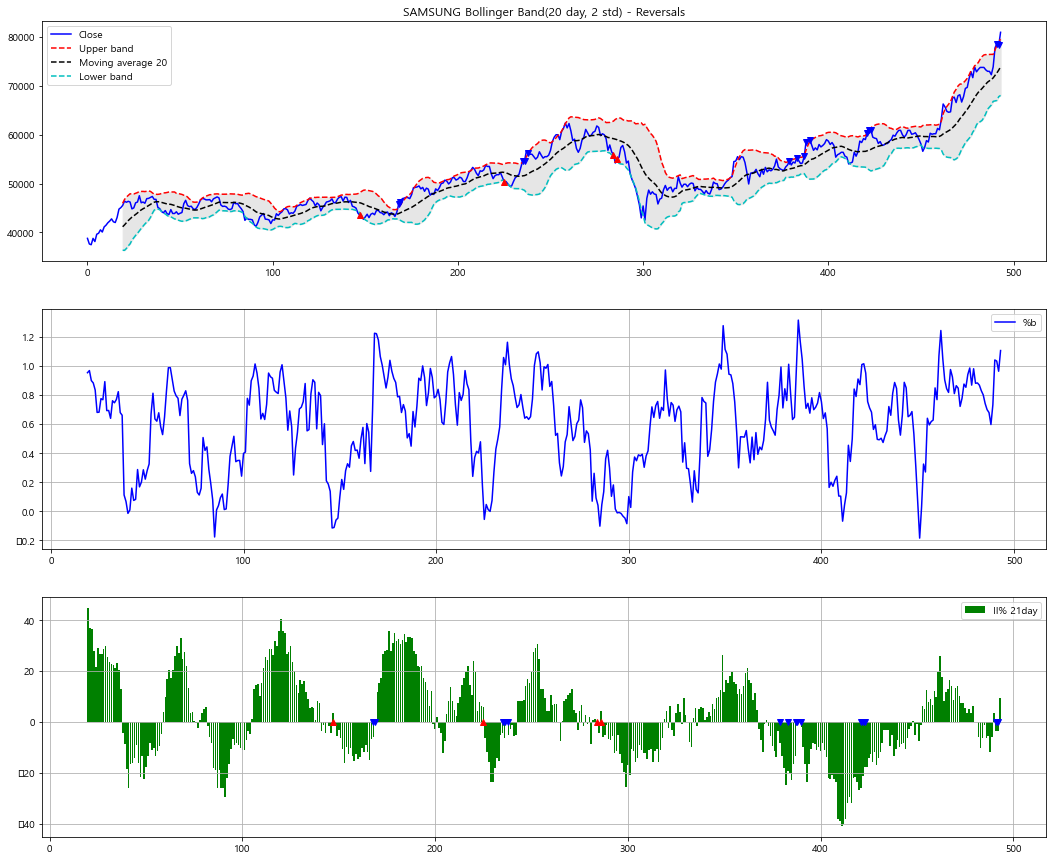

In [13]:
plt.figure(figsize=(18,15))
plt.subplot(3,1,1)
plt.title('SAMSUNG Bollinger Band(20 day, 2 std) - Reversals')
plt.plot(df.index, df['close'], 'b', label='Close')
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df.close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], df.close.values[i], 'r^')
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], df.close.values[i], 'bv')


plt.legend(loc = 'best')
plt.subplot(3,1,2)
plt.plot(df.index, df['PB'], 'b', label='%b')
plt.grid(True)
plt.legend(loc = 'best')

plt.subplot(3,1,3)
plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')
for i in range(0, len(df.close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()